In [1]:
import os
import pickle
import sys
sys.path.append('../')
from src.FeatureExtractor import FeatureExtractor
from src.Video import Video
from src.Frame import Frame

project_dir = os.path.dirname(os.getcwd())

svc_pickle = pickle.load(open(os.path.join(project_dir, "hog_color.pkl"), "rb"))
features = svc_pickle["features"]  # color, space, hog
color_space = svc_pickle["color_space"]

feature_extractor = FeatureExtractor(features[0], features[1], features[2], color_space)
svc = svc_pickle["svc"]
X_scaler = svc_pickle["X_scaler"]

if features[0]:  # color features
    hist_bins = svc_pickle["histbin"]
    hist_range = svc_pickle["hist_range"]
    feature_extractor.init_color_parameters(hist_bins, hist_range)
if features[1]:  # space features
    spatial_size = svc_pickle["spatial"]
    feature_extractor.init_space_parameters(spatial_size)
if features[2]:
    orient = svc_pickle["orient"]
    pix_per_cell = svc_pickle["pix_per_cell"]
    cell_per_block = svc_pickle["cell_per_block"]
    hog_channel = svc_pickle["hog_channel"]
    feature_extractor.init_hog_parameters(orient, pix_per_cell, cell_per_block, hog_channel)
    
distortion_pickle = pickle.load(open(os.path.join(project_dir, "dist_pickle.p"), "rb"))
mtx = distortion_pickle["mtx"]
dist = distortion_pickle["dist"]
    
video = Video("", "", X_scaler, svc, feature_extractor)
Frame.init(1280, 720, mtx, dist)

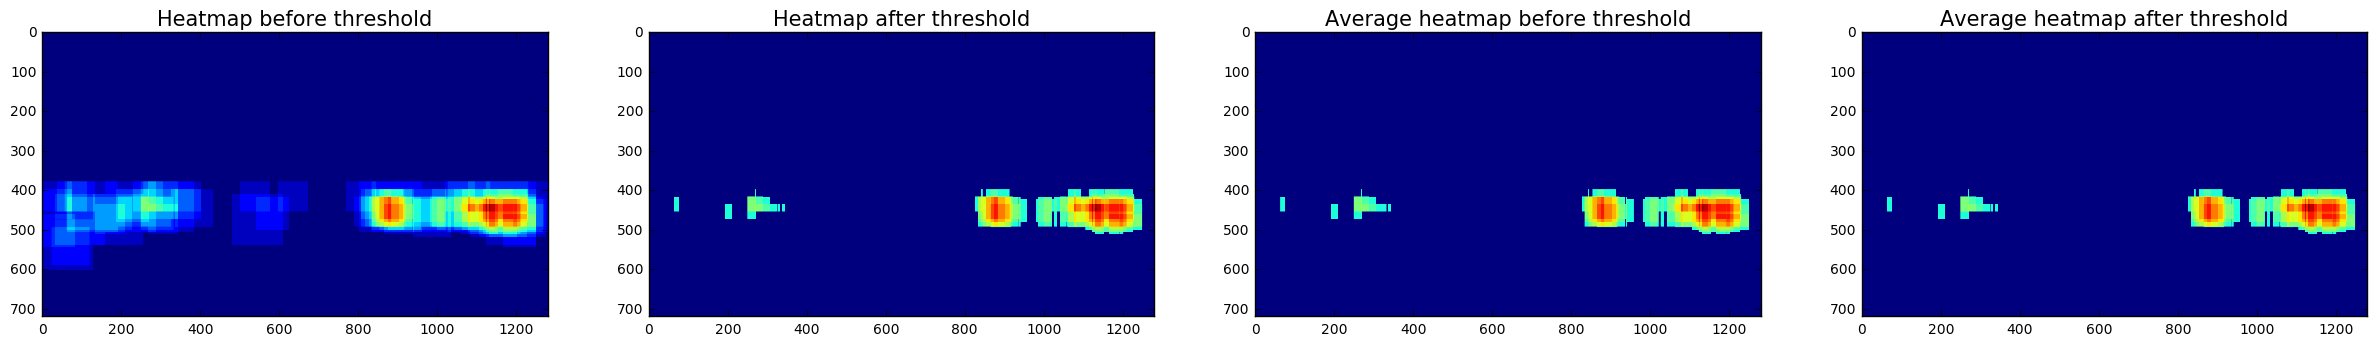

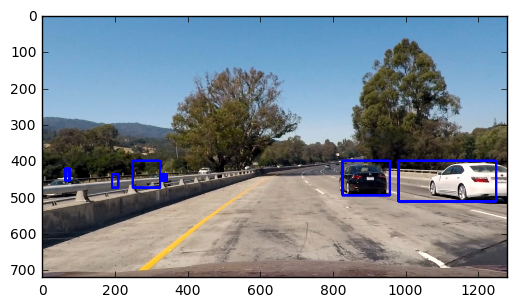

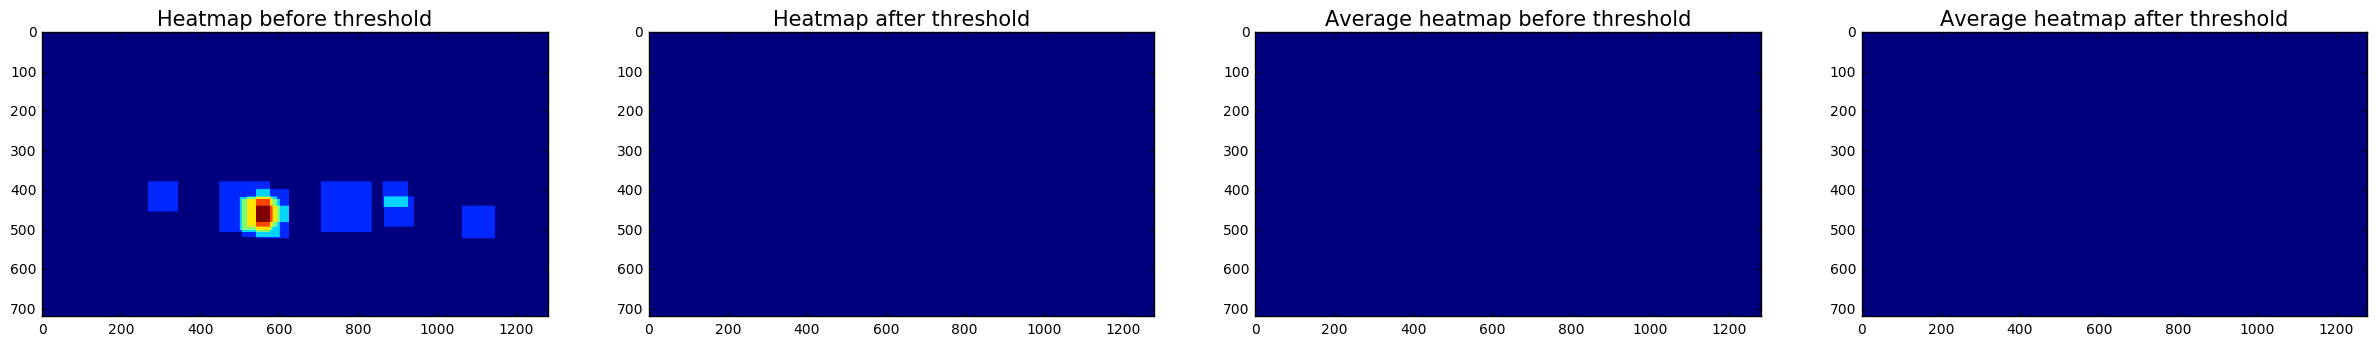

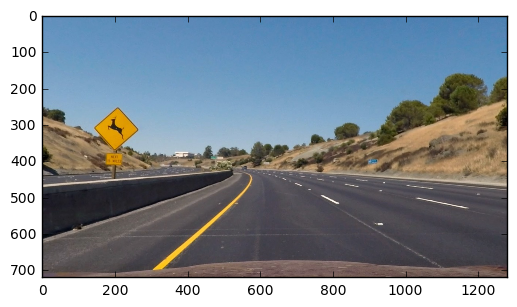

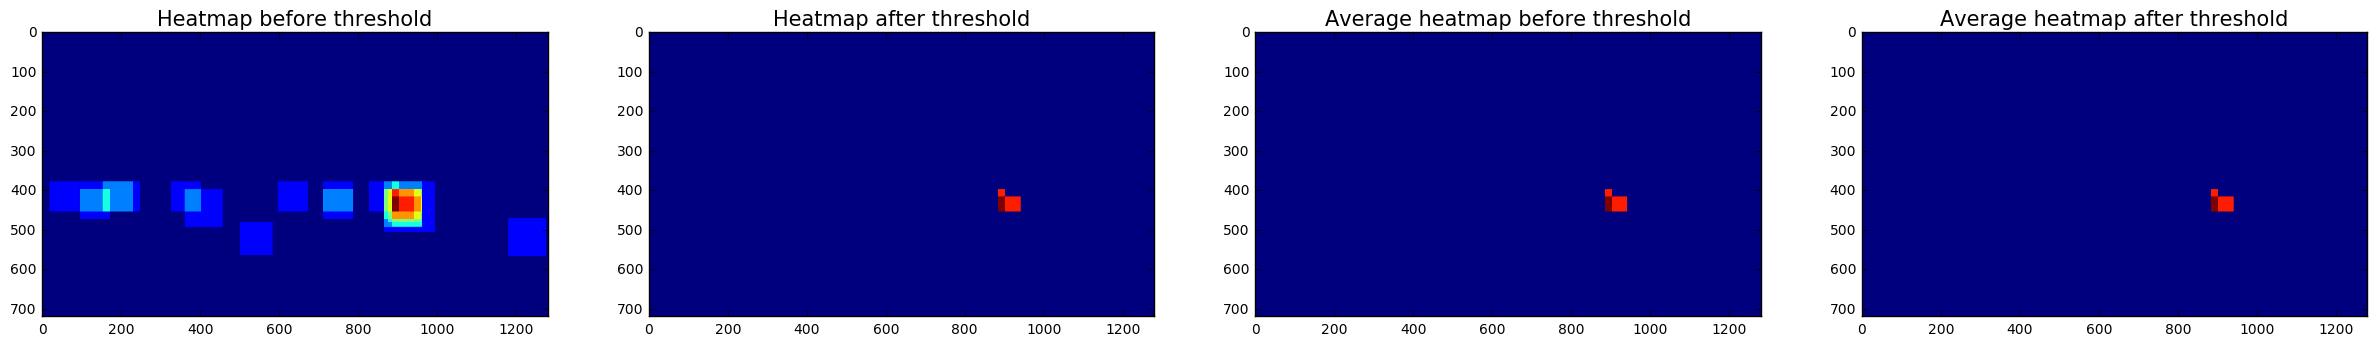

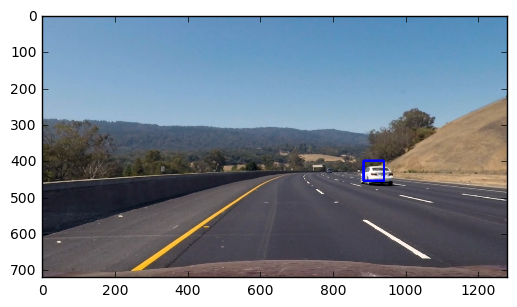

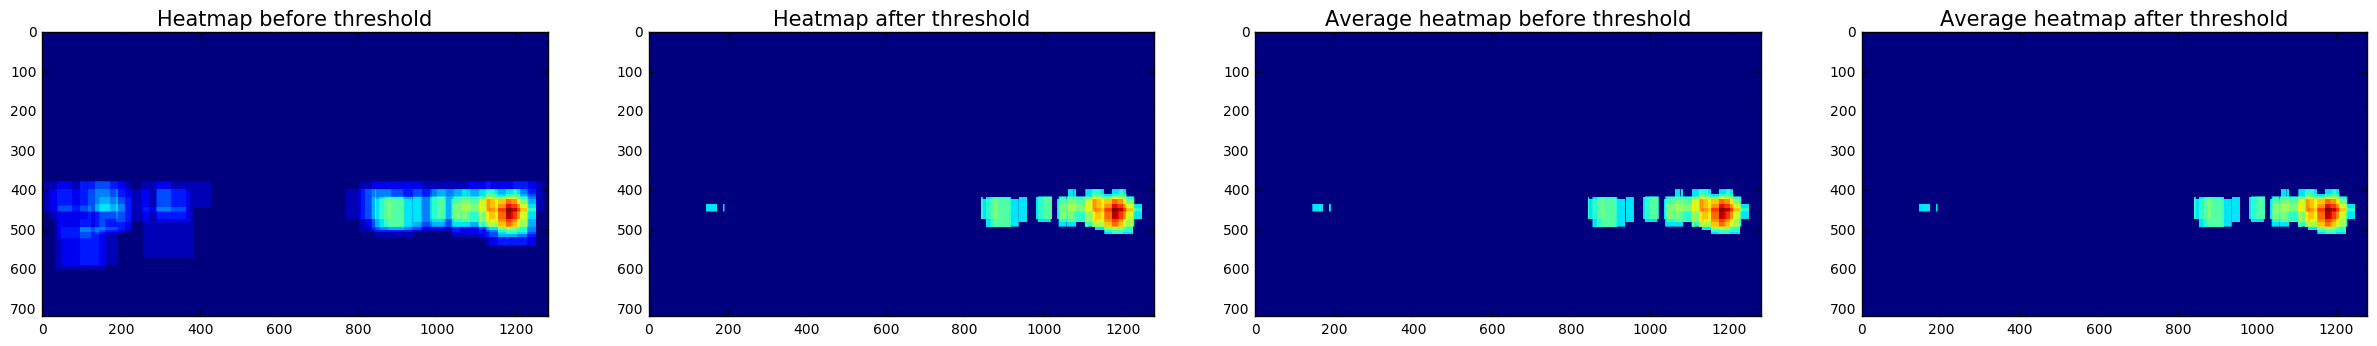

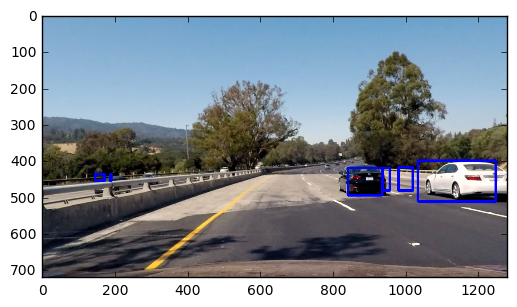

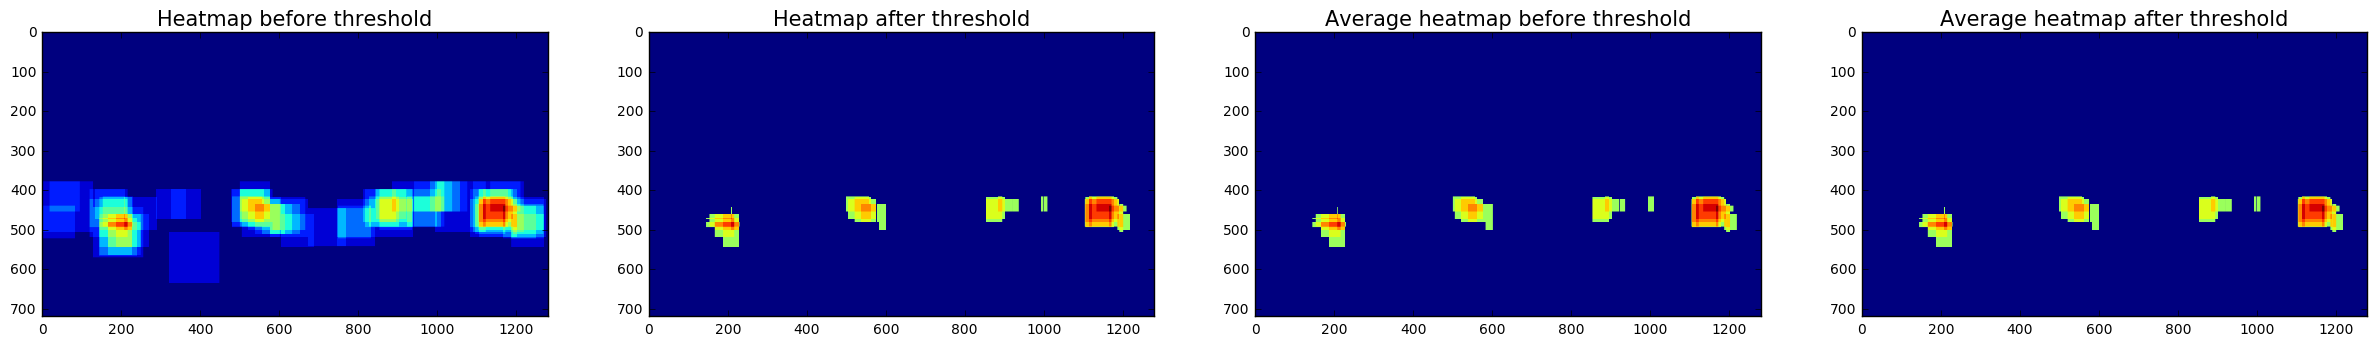

In [ ]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import deque
from scipy.ndimage.measurements import label
%matplotlib inline

path = os.path.join(project_dir, 'test_images', '*.jpg')
images = glob.glob(path)
for image_path in images:  
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    current_frame = Frame(rgb_image)
    
    #labels = video.vehicle_detector.run_detector(current_frame.img)
    video.vehicle_detector.heatmap_history = deque([])
    #video.vehicle_detector.average_heatmap = np.array([])
    video.vehicle_detector.init_heatmap(1280, 720)
    
    box_list = video.vehicle_detector.slider.find_cars(image)

    video.vehicle_detector.current_heatmap = np.zeros_like(image[:, :, 0]).astype(np.float)
    video.vehicle_detector.add_heat(box_list)
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,10))
    ax1.imshow(video.vehicle_detector.current_heatmap)
    ax1.set_title('Heatmap before threshold', fontsize=15)
    

    # remove noise
    video.vehicle_detector.apply_threshold(video.vehicle_detector.current_heatmap, 6)
    ax2.imshow(video.vehicle_detector.current_heatmap)
    ax2.set_title('Heatmap after threshold', fontsize=15);

    # add the latest heatmap for averaging and in history
    video.vehicle_detector.average_heatmap += video.vehicle_detector.current_heatmap
    video.vehicle_detector.heatmap_history.append(video.vehicle_detector.current_heatmap)

    if len(video.vehicle_detector.heatmap_history) >= video.vehicle_detector.n:
        # remove too old heatmap from history and averaging
        old_heatmap = video.vehicle_detector.heatmap_history.popleft()
        video.vehicle_detector.average_heatmap -= old_heatmap
        
    ax3.imshow(video.vehicle_detector.average_heatmap)
    ax3.set_title('Average heatmap before threshold', fontsize=15);

    # it's important to leave original average_heatmap unchanged
    # so, it will be possible to track ALL latest predictions
    heatmap_copy = np.copy(video.vehicle_detector.average_heatmap)
    video.vehicle_detector.apply_threshold(heatmap_copy, 4*len(video.vehicle_detector.heatmap_history))
    
    ax4.imshow(heatmap_copy)
    ax4.set_title('Average heatmap after threshold', fontsize=15);
    
    labels = label(heatmap_copy)
    
    
    result = current_frame.draw_labeled_bboxes(labels)
    
    plt.figure()
    plt.imshow(result)